## Introduction to the COVID-19 Open Research Dataset

The COVID-19 Open Research Dataset (CORD-19) is a collection of over 50,000 scholarly articles - including over 40,000 with full text - about COVID-19, SARS-CoV-2, and related coronaviruses. This dataset has been made freely available with the goal to aid research communities combat the COVID-19 pandemic. It has been made available by the Allen Institute for AI in partnership with leading research groups to prepare and distribute the COVID-19 Open Research Dataset (CORD-19), in response to the COVID-19 pandemic.

During this lab you will learn how to process and analyze a subset of the articles present in the dataset, group them together into a series of clusters, and use Automated ML to train a machine learning model capable of classifying new articles as they are published.

### Setup

We will start off by installing a few packages, such as `nltk` for text processing and `wordcloud`, `seaborn`, and `yellowbrick` for various visualizations.

In [1]:
%pip install nltk
%pip install wordcloud
%pip install seaborn
%pip install yellowbrick


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


We'll first download stopwords and the Punkt tokenizer models present in the `nltk` package, in order to be able to process the articles

In [2]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

We'll also import the rest of the modules needed in this notebook, and do a quick sanity-check on the Azure ML SDK version

In [3]:
import os
import json
from string import punctuation

import pandas as pd
import seaborn as sns
sns.set_palette('Set2')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, Birch, AgglomerativeClustering
from sklearn.metrics import roc_auc_score
from nltk import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer, PorterStemmer

from azureml.core import Workspace, Datastore, Dataset, VERSION

print("Azure ML SDK Version: ", VERSION)

Azure ML SDK Version:  1.39.0


## Load the Covid-19 data

CORD-19 has been uploaded to an Azure Storage Account, we will connect to it and use it's API to download the dataset locally. Also please make sure to update the storage account name from the labguide in the below cell. 

In [4]:
covid_dirname = 'covid19temp'

cord19_dataset = Dataset.File.from_files('https://aiinadaystorage800633.blob.core.windows.net/' + covid_dirname )
mount = cord19_dataset.mount()

covid_dirpath = os.path.join(mount.mount_point, covid_dirname)

Display a sample of the dataset (top 5 rows).

In [5]:
mount.start()

# Load metadata.csv, as it contains a list of all the articles and their corresponding titles/authors/contents.
metadata_filename = os.path.join(covid_dirpath, 'metadata.csv')

metadata = pd.read_csv(metadata_filename)
metadata.sample(5)

/tmp/ipykernel_21867/188001440.py:6: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(metadata_filename)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
114731,3uohifp9,1f5870b66e190afa3f7876fa16b2bef39c35171d,Elsevier; Medline; PMC,"A Stroke Care Model at an Academic, Comprehens...",10.1016/j.jstrokecerebrovasdis.2020.104927,PMC7205687,32434728.0,els-covid,Abstract Background and Purpose The COVID-19 p...,2020-05-08,"Meyer, Dawn; Meyer, Brett C.; Rapp, Karen S.; ...",J Stroke Cerebrovasc Dis,NaN,NaN,NaN,document_parses/pdf_json/1f5870b66e190afa3f787...,document_parses/pmc_json/PMC7205687.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/32434728/;...,218538727.0
23682,2x5y2x7f,NaN,PMC,Classification and pathogenicity of microbes,10.1016/b978-0-7236-1403-6.50010-7,PMC7173597,NaN,no-cc,This chapter discusses the classification and ...,2014-06-27,"Shanson, D.C.",Microbiology in Clinical Practice,NaN,NaN,NaN,NaN,document_parses/pmc_json/PMC7173597.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN
118136,y47p1c15,9957b4db7aa7da8f192339b4f820a51fd209fcd8,Medline; PMC,Ambient bioaerosol distribution and associated...,10.1007/s10661-020-8158-9,PMC7087893,32086610.0,no-cc,Traffic junctions are one of the crowded place...,2020-02-22,"Madhwal, Sandeep; Prabhu, Vignesh; Sundriyal, ...",Environ Monit Assess,NaN,NaN,NaN,document_parses/pdf_json/9957b4db7aa7da8f19233...,document_parses/pmc_json/PMC7087893.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/32086610/;...,211234534.0
106949,ogk5b7ug,fcb00e5562336142b9e0dcaf808ab41795282e0e,PMC; WHO,A Post-Truth Proactionary Look at the Pandemic,10.1007/s42438-020-00124-5,PMC7169651,NaN,no-cc,NaN,2020-04-20,"Fuller, Steve",Postdigit Sci Educ,NaN,#88354,NaN,document_parses/pdf_json/fcb00e5562336142b9e0d...,document_parses/pmc_json/PMC7169651.xml.json,https://doi.org/10.1007/s42438-020-00124-5,216036653.0
118705,8xwahrke,d7873075465b9adee896a5ca2f63c819efceea08,Elsevier; Medline; PMC,How to prevent outbreak of a hospital-affiliat...,10.1016/j.jmii.2020.04.007,PMC7152916,32305270.0,els-covid,NaN,2020-04-13,"Huang, Hsuan-Ti; Chen, Tun-Chieh; Liu, Tzu-Yin...",J Microbiol Immunol Infect,NaN,NaN,NaN,document_parses/pdf_json/d7873075465b9adee896a...,NaN,https://doi.org/10.1016/j.jmii.2020.04.007; ht...,215741074.0


Some of the articles do not have any associated documents, so we will filter those out.

In [6]:
metadata_with_docs = metadata[metadata['pdf_json_files'].isna() == False]

print(f'Dataset contains {metadata.shape[0]} entries, out of which {metadata_with_docs.shape[0]} have associated json documents')

Dataset contains 134206 entries, out of which 56962 have associated json documents


Display the percentage of items in the dataset that have associated JSON documents (research papers that have extra metadata associated with them).

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


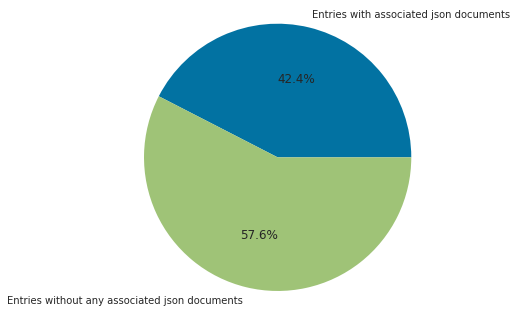

In [7]:
doc_counts = [metadata_with_docs.shape[0], metadata.shape[0] - metadata_with_docs.shape[0]]
doc_labels = ['Entries with associated json documents', 'Entries without any associated json documents']

fig, ax = plt.subplots()
ax.pie(doc_counts, labels=doc_labels, autopct='%1.1f%%')
ax.axis('equal')
plt.show()

## Investigate individual items

Let's load an example entry from the dataset.

In [8]:
# Change the document index in order to preview a different article
DOCUMENT_INDEX = 0 
example_entry = metadata_with_docs.iloc[DOCUMENT_INDEX]

filepath = os.path.join(covid_dirpath, example_entry['pdf_json_files'])
print(f'Document local filepath: {filepath}')
print(f'Document local filepath: {covid_dirpath}')

filepath = covid_dirpath + '/comm_use_subset/pdf_json/02a009e42054081b441d0f4b203679c4b0cae38d.json'
print(f'Document local filepath: {filepath}')

Document local filepath: /tmp/tmpuit5h08p/covid19temp/document_parses/pdf_json/d1aafb70c066a2068b02786f8929fd9c900897fb.json
Document local filepath: /tmp/tmpuit5h08p/covid19temp
Document local filepath: /tmp/tmpuit5h08p/covid19temp/comm_use_subset/pdf_json/02a009e42054081b441d0f4b203679c4b0cae38d.json


Next, we will display the list of elements that are available for the selected document.

In [9]:
try:
    with open(filepath, 'r') as f:
        data = json.load(f)
        
except FileNotFoundError as e:
    # in case the mount context has been closed
    mount.start()
    with open(filepath, 'r') as f:
        data = json.load(f)
        
print(f'Data elements: { ", ".join(data.keys())}' )

Data elements: paper_id, metadata, abstract, body_text, bib_entries, ref_entries, back_matter


Please make sure to update the storage account name from the labguide in the below cell.

In [ ]:
from azureml.core import  Dataset
cord19_dataset = Dataset.File.from_files('https://aiinadaystorage800633.blob.core.windows.net/covid19temp')
mount = cord19_dataset.mount()

View the full text version of the document.

In [ ]:
for p in data['body_text']:
    print(p['text'], '\n')

## Stop words

Here's a quote from Stanford's NLP team that will provide some context on stop words and their intended usage:

_"Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words . The general strategy for determining a stop list is to sort the terms by collection frequency (the total number of times each term appears in the document collection), and then to take the most frequent terms, often hand-filtered for their semantic content relative to the domain of the documents being indexed, as a stop list , the members of which are then discarded during indexing."_

Let's investigate the stop words list that we will use to clean our data. Note that apart from the standard stopwords, we will also remove any punctuation and also any occurrences of *et al.*, as they are often found in academic articles.

In [ ]:
stop_tokens = nltk.corpus.stopwords.words('english') + list(punctuation) + ['et', 'al.']
print(stop_tokens)

The code below will be used to read the text associated with a series of articles, remove stop words from their text, and reduce) inflected words to their base form (stemming).

**NOTE**:

If you are not familiar with Python code, just execute the following cell and continue with the notebook. Understanding the code below is not require for understanding and following the overall flow of the notebook.

In [ ]:
class Reader:
    """Class used to read the files associated with an article"""
    
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
    
    def read_file_to_json(self, filepath):
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)
        except FileNotFoundError as e:
            mount.start()
            with open(filepath, 'r') as f:
                data = json.load(f)
                
        return data
    
    def parse_document(self, document_index):
        document = metadata_with_docs.iloc[document_index]
        
        # One article can have multiple associated documents
        words = []
        for filename in document['pdf_json_files'].split('; '):
            filepath = '{0}/{1}'.format(covid_dirpath, filename)
            pdf_json_files = os.listdir(covid_dirpath + '/comm_use_subset/pdf_json')
            filepath = covid_dirpath + '/comm_use_subset/pdf_json/' + pdf_json_files[document_index]
            
            if document_index % 50 == 0:
                print(filepath)
            
            data = self.read_file_to_json(filepath)



           # Split each paragraph into multiple sentences first, in order to improve the performance of the word tokenizer
            text = data['body_text']
            for paragraph in text:
                p_sentences = sent_tokenize(paragraph['text'])



               # Split each sentence into words, while making sure to remove the stopwords and stem the words
                for p_sentence in p_sentences:
                    sentence = [ self.stemmer.stem(word) for word in word_tokenize(p_sentence) if word.isalpha() and word.lower() not in stop_tokens ]
                    words.extend(sentence)
    
        return (words, document['cord_uid'])
        



class Corpus:
    """An iterator that reads all sentences from the first N documents"""
    
    def __init__(self, n_documents):
        self.n_documents = n_documents
        self.stemmer = SnowballStemmer('english')
        self.reader = Reader()
        
    def __iter__(self):
         for document_index in range(0, self.n_documents):   
            words, document_id = self.reader.parse_document(document_index)
            yield TaggedDocument(words, document_id)
            
    def plain_iter(self):
        for document_index in range(0, self.n_documents):  
            words, document_id = self.reader.parse_document(document_index)
            yield (words, document_id)

## Encoding documents as vectors

In this lab, we're using a subset of 1000 articles to train a Machine Learning model that encodes text documents into numerical vectors (a document embedding model). 

Training a document embedding model takes a significant amount of time, and for this reason we already provide a trained model. We also provide the code below in case you want to get more details about the process. Running the next two cells will result in loading the already existing model.

In [ ]:
N_DOCUMENTS = 500

In [ ]:
%%time

model_filename = f'covid_embeddings_model_{N_DOCUMENTS}_docs.w2v'

if (os.path.exists(model_filename)):
    model = Doc2Vec.load(model_filename)
    print(f'Done, loaded word2vec model with { len(model.wv.vocab) } words.')
else:
    model = Doc2Vec(Corpus(N_DOCUMENTS), vector_size=128, batch_words=10)
    model.save(model_filename)
    print(f'Done, trained word2vec model with { len(model.wv.vocab) } words.')

## Word frequencies

Let's analyze the relative frequencies of words in the corpus of articles. We will display a word cloud to provide a visual representation of these relative frequencies.

In [ ]:
word_frequencies = { key: model.wv.vocab[key].count for key in model.wv.vocab }

In [ ]:
cloud = WordCloud(width=1024, height=768).generate_from_frequencies(word_frequencies)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='antialiased')
plt.axis("off")

## Embedding documents

Below is an example on how we embed (transform from text to numerical vector) one of the documents.

In [ ]:
words, doc_id = Reader().parse_document(DOCUMENT_INDEX)
model.infer_vector(words)

And this is an example of a trivial "document" (containing a single, trivial sentence) going through the same process. Notice how, regardless of the length of the sentence, the result vector is always the same size - the `vector_size` argument used while training the `Doc2Vec` model.

This is very important in the following stages of the process, when we are working with multiple documents.

In [ ]:
model.infer_vector(['human', 'love', 'cat', 'dog'])

The resulting vectors will look more or less similar, depending on how different the contents of the articles are themselves. See below the differences resulting from a single word change - some of the values significantly overlap, while others are quite different if not opposite.

In [ ]:
adult_vector = model.infer_vector(['adult', 'love', 'cat', 'dog'])
child_vector = model.infer_vector(['child', 'love', 'cat', 'dog'])
labels = range(0, 128) 

plt.bar(labels, adult_vector, align='center', alpha=0.5)
plt.bar(labels, child_vector, align='center', alpha=0.5)
plt.legend(['Adults', 'Children'])
plt.show()

Let's now do the same for the same for all the documents we're focusing on.

In [ ]:
%%time

word_vectors = []
ids = []

for (words, doc_id) in Corpus(N_DOCUMENTS).plain_iter():
    ids.append(doc_id)
    word_vector = model.infer_vector(words)
    word_vectors.append(word_vector)
    if len(word_vectors) % 100 == 0:
        print(f'Processed {len(word_vectors)} documents.')

Now that we've finished reading the articles, we can dismount the dataset in order to free up resources

In [ ]:
mount.stop()

## Covid-19 documents prepared for Machine Learning

We'll create a new DataFrame using the word vectors we've just calculated, this is the numerical form of the documents which is ready for Machine Learning workloads.

In [ ]:
wv_df = pd.DataFrame(word_vectors, index=ids)
wv_df

We'll join the DataFrame containing the numerical embeddings with the original dataset.

In [ ]:
indexed_metadata = metadata_with_docs.set_index('cord_uid')
metadata_with_embeddings = pd.concat([indexed_metadata.iloc[:N_DOCUMENTS], wv_df], axis=1)
metadata_with_embeddings

## Preparing for clustering documents

One of the challenges with clustering is to find the ideal number of clusters to look for. The elbow method is one of the most common approaches.

We're visualizing an elbow metric (the "distortion" score) and trying to find a point where it stops decreasing with the number of clusters.


In [ ]:
visualizer = KElbowVisualizer(KMeans(), k=(3,20))
visualizer.fit(wv_df)

visualizer.show()

## Clustering documents

We've determined the acceptable value for the clusters, so let's use Machine Learning to determine those clusters. We'll use the classic KMeans algorithm to do this.

In [ ]:
clusterer = KMeans(12 if visualizer.elbow_value_ > 12 else visualizer.elbow_value_)
clusterer.fit(wv_df)
clusters = clusterer.labels_

We'll perform a quick visual check on the clusters. In order to be able to visualize 128 dimensions (which is the size of the word vectors) in a 2-D space, we'll use the PCA (Principal Component Analysis) dimensionality reduction technique. This will transform our 128-dimensional vectors into 2-dimensional ones that we can display.

In [ ]:
pca = PCA(n_components=2)
pca.fit(wv_df)
result = pca.transform(wv_df)

Afterwards, we can plot the documents in a simple 2-D chart, and color each one according to their cluster

In [ ]:
sns.set(rc={'figure.figsize':(10, 6), 'figure.facecolor':'white', 'axes.facecolor':'white'})

color_palette = sns.color_palette('Paired')
# Each cluster gets its own color from the palette
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
plt.scatter(result[:,0], result[:,1], s=50, c=cluster_colors, alpha=0.75)

plt.title(f'{N_DOCUMENTS} documents in {clusterer.n_clusters} clusters')
plt.show()

We'll add each article's cluster as new column to our combined dataset

In [ ]:
metadata_with_clusters = metadata_with_embeddings
metadata_with_clusters['cluster'] = clusters
metadata_with_clusters

We can now split our data into two datasets - a **training** one that will be used to train a Machine Learning model, able to determine the cluster that should be assigned to an article, and a **test** one that we'll use to test this classifier.

We will allocate 80% of the articles to training the Machine Learning model, and the remaining 20% to testing it.

In [ ]:
train, test = train_test_split(metadata_with_clusters, train_size=0.8)
train

To speed up training, we'll ignore all columns except the word vectors calculated using Doc2Vec. For this reason, we will create a separate dataset just with the vectors.

In [ ]:
columns_to_ignore = ['sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
                     'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files', 'url', 's2_id' ]
train_data_vectors = train.drop(columns_to_ignore, axis=1)
test_data_vectors = test.drop(columns_to_ignore, axis=1)

## Register the training and testing datasets for AutoML availability

We're registering the training and testing datasets with the Azure Machine Learning datastore to make them available inside Azure Machine Learning Studio and Automated ML.

In [ ]:
# Retrieve your ML workspace
ws = Workspace.from_config()
# Retrieve the workspace's default datastore
datastore = ws.get_default_datastore()


Dataset.Tabular.register_pandas_dataframe(train_data_vectors, datastore, 'COVID19Articles_Train_Vectors')
Dataset.Tabular.register_pandas_dataframe(test_data_vectors, datastore, 'COVID19Articles_Test_Vectors')

## Open Azure Machine Learning Studio

Return to the GitHub repo and follow the instructions from there. You will use Automated ML in Azure Machine Learning Studio to train a classification model that predicts the document cluster for new research articles.